In [1]:
import os
import jax
import pickle

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'
jax.config.update('jax_platform_name', 'cpu')

#from jax.config import config; config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html, model
from brax.training import normalization

import flax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController

from ce_apg import do_one_rollout, cem_apg

from functools import partial

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

save_dir = "ceapg_acro2"

0.009375826


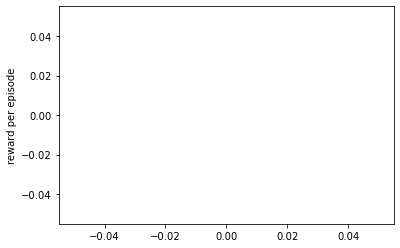

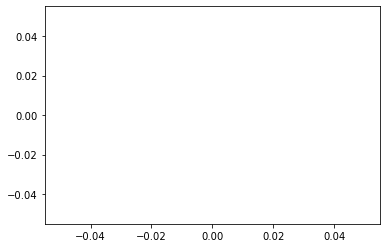

 Iteration 1 --------------------------------
0 : reward: 21.0 -> nan
1 : reward: 22.0 -> nan
2 : reward: 20.0 -> nan
3 : reward: 31.0 -> nan
4 : reward: 21.0 -> nan
5 : reward: 20.0 -> nan
6 : reward: 24.0 -> nan
7 : reward: 20.0 -> nan
---
8 : reward: 23.0 -> nan
9 : reward: 22.0 -> nan
10 : reward: 19.0 -> nan
11 : reward: 24.0 -> nan
12 : reward: 22.0 -> nan
13 : reward: 21.0 -> nan
14 : reward: 24.0 -> nan
15 : reward: 23.0 -> nan
16 : reward: 20.0 -> nan
17 : reward: 23.0 -> nan
18 : reward: 21.0 -> nan
19 : reward: 23.0 -> nan
20 : reward: 22.0 -> nan
21 : reward: 24.0 -> nan
22 : reward: 21.0 -> nan
23 : reward: 22.0 -> nan
-------------------------------------------------
cem: nan -> 22.0



In [2]:
env_name = "inverted_pendulum" # "acrobot", "inverted_pendulum_swingup", "inverted_double_pendulum_swingup"]:
episode_length = 500
action_repeat = 1
env_fn = create_fn(env_name = env_name, episode_length=episode_length, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()

policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
print(policy_size)
policy = GruController(env.observation_size, env.action_size, policy_size)
pickle.dump(policy, open(f"{save_dir}/{env_name}_policy", 'wb'))

seed = 3
inference_fn, params, rewards = cem_apg(env_fn,
                                        2,
                                        key=jax.random.PRNGKey(seed),
                                        episode_length = episode_length,
                                        action_repeat = action_repeat,
                                        apg_epochs = 75,
                                        batch_size = 0,
                                        zero_params=False,
                                        truncation_length = None,
                                        learning_rate = 1e-4,
                                        clipping = 1e9,
                                        initial_std = 0.01,
                                        num_elite = 8,
                                        eps = 0.0,
                                        normalize_observations=True,
                                        policy = policy,
                                        learning_schedule = [-3, -6]
                                       )

model.save_params(f"{save_dir}/{env_name}_params_{seed}", params)
pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{seed}", "wb"))



In [7]:
from brax.io import model
import ce_apg

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)
h = np.zeros_like(state.obs)
r = []

while not state.done:
  rollout.append(state)
  r.append(state.reward)
  h, act = jit_inference_fn(params, h, state.obs)
  state = jit_env_step(state, act)

print(sum(r))
HTML(html.render(env.sys, [s.qp for s in rollout]))

4997.4023
